# Fishing Detection: Exploratory Analysis & Model Improvement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import geopandas as gpd
from shapely.geometry import Point

# Set up plotting
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

C:\Users\oscar\AppData\Local\Temp\ipykernel_23440\3985954218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Part 1: Initial Data Loading and Exploration

Load the data and get a basic understanding of its structure, quality, and contents.

In [2]:

print("Loading data...")
df = pd.read_csv('../data/raw/drifting_longlines.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nSummary statistics:")
print(df.describe())

# Basic understanding of vessel distribution
print("\nNumber of unique vessels:")
print(df['mmsi'].nunique())

Loading data...
Dataset shape: (13968727, 10)

First few rows:
           mmsi     timestamp  distance_from_shore  distance_from_port  speed  \
0  1.263956e+13  1.327137e+09        232994.281250        311748.65625    8.2   
1  1.263956e+13  1.327137e+09        233994.265625        312410.34375    7.3   
2  1.263956e+13  1.327137e+09        233994.265625        312410.34375    6.8   
3  1.263956e+13  1.327143e+09        233994.265625        315417.37500    6.9   
4  1.263956e+13  1.327143e+09        233996.390625        316172.56250    6.1   

       course        lat        lon  is_fishing               source  
0  230.500000  14.865583 -26.853662        -1.0  dalhousie_longliner  
1  238.399994  14.863870 -26.856800        -1.0  dalhousie_longliner  
2  238.899994  14.861551 -26.860649        -1.0  dalhousie_longliner  
3  251.800003  14.822686 -26.865898        -1.0  dalhousie_longliner  
4  231.100006  14.821825 -26.867579        -1.0  dalhousie_longliner  

Data types:
mmsi       

## Part 2: Data Preprocessing

Preprocess the data by converting timestamps, extracting features, handling missing values, and creating binary labels.

In [4]:
print("\nPreprocessing data...")
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
# Extract time components
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Check for outliers in speed
print("\nSpeed distribution:")
print(df['speed'].describe())

# Remove speed outliers
# Remove extreme speed outliers (above 99.9th percentile)
speed_threshold = df['speed'].quantile(0.999)
print(f"\nRemoving speeds above {speed_threshold:.2f} knots")
df = df[df['speed'] <= speed_threshold]

# Also remove any negative speeds as they are invalid
print(f"Removing {len(df[df['speed'] < 0])} negative speed values")
df = df[df['speed'] >= 0]


# Check fishing label distribution
print("\nFishing label distribution (original):")
print(df['is_fishing'].value_counts())

# Convert fishing label to binary (removing -1 values)
df = df[df['is_fishing'] >= 0]  # Remove no-data points
df['is_fishing_binary'] = (df['is_fishing'] > 0).astype(int)

print("\nFishing label distribution (binary):")
print(df['is_fishing_binary'].value_counts())
print(f"Fishing percentage: {df['is_fishing_binary'].mean()*100:.2f}%")


Preprocessing data...

Speed distribution:
count    1.396863e+07
mean     5.464779e+00
std      4.043567e+00
min      0.000000e+00
25%      2.100000e+00
50%      5.500000e+00
75%      8.500000e+00
max      1.023000e+02
Name: speed, dtype: float64

Removing speeds above 13.60 knots
Removing 0 negative speed values

Fishing label distribution (original):
is_fishing
-1.000000    13735160
 1.000000      138023
 0.000000       79521
 0.666667        1076
 0.333333         809
 0.750000         110
 0.250000           9
Name: count, dtype: int64

Fishing label distribution (binary):
is_fishing_binary
1    140027
0     79521
Name: count, dtype: int64
Fishing percentage: 63.78%


## Part 3: Data Visualization

Visualize distributions, temporal patterns, and spatial distributions.


Creating visualizations...

Generating map visualization...
Map saved to fishing_map.html


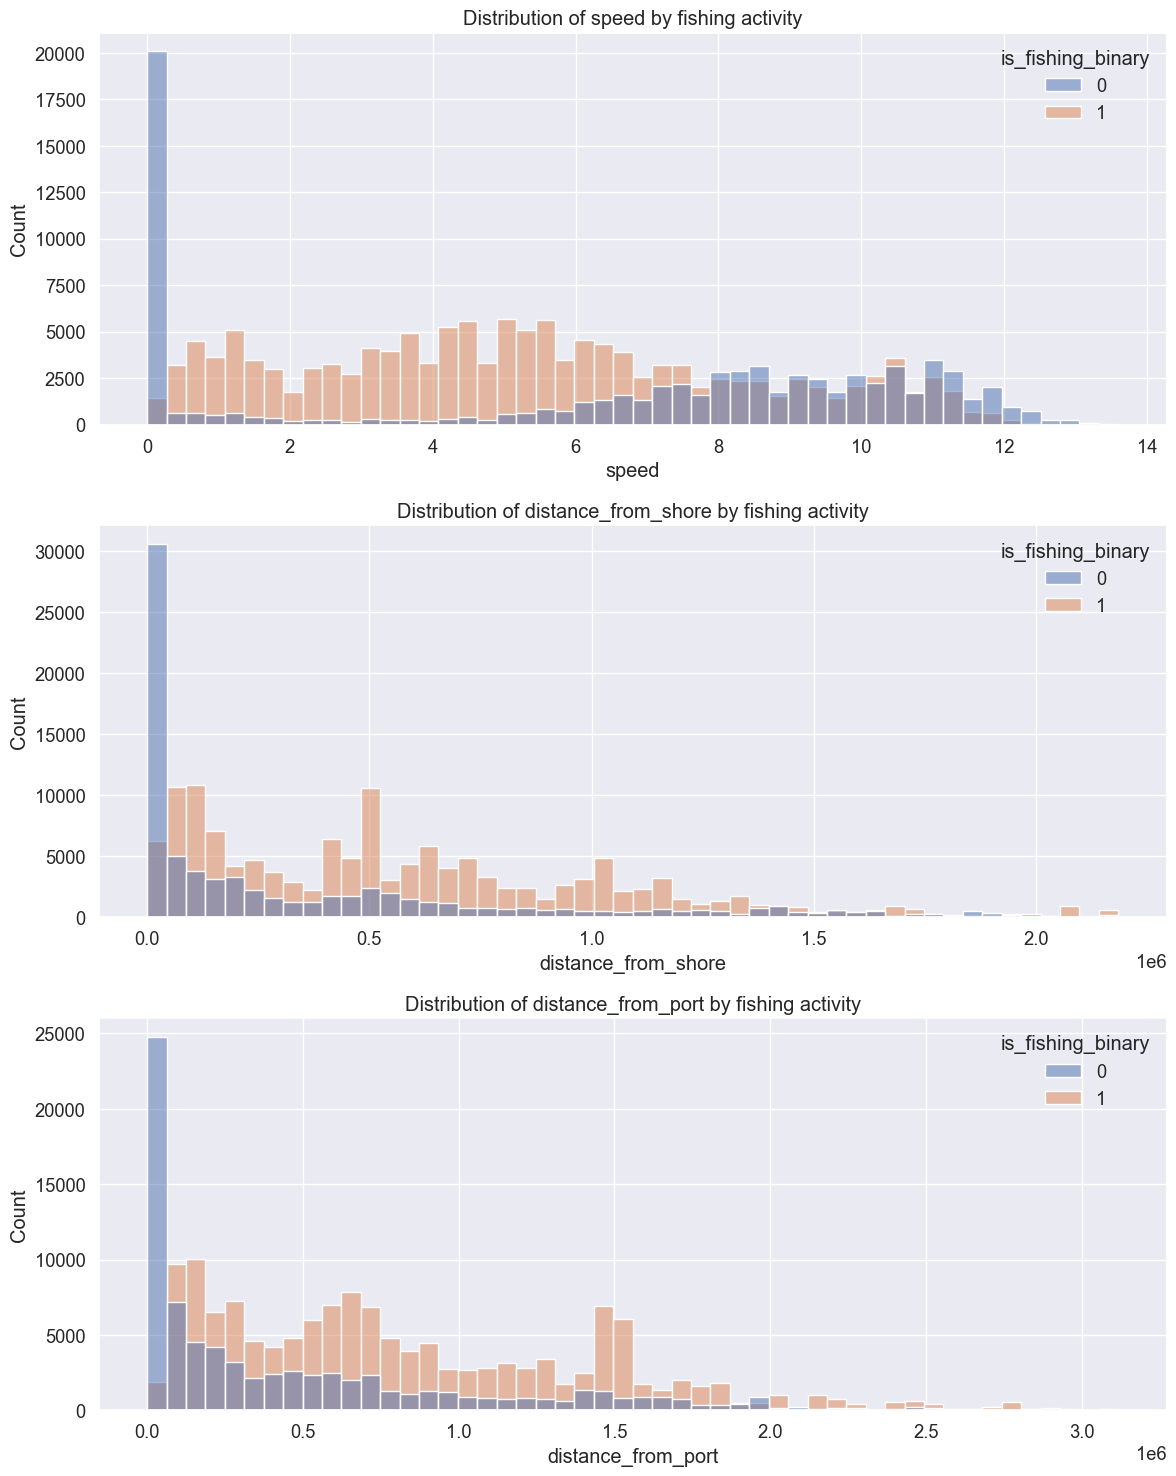

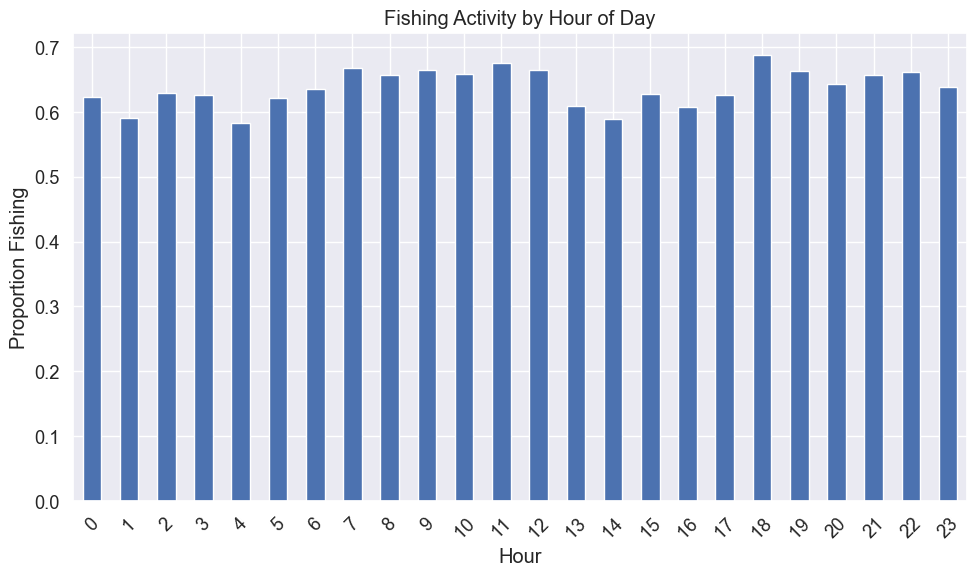

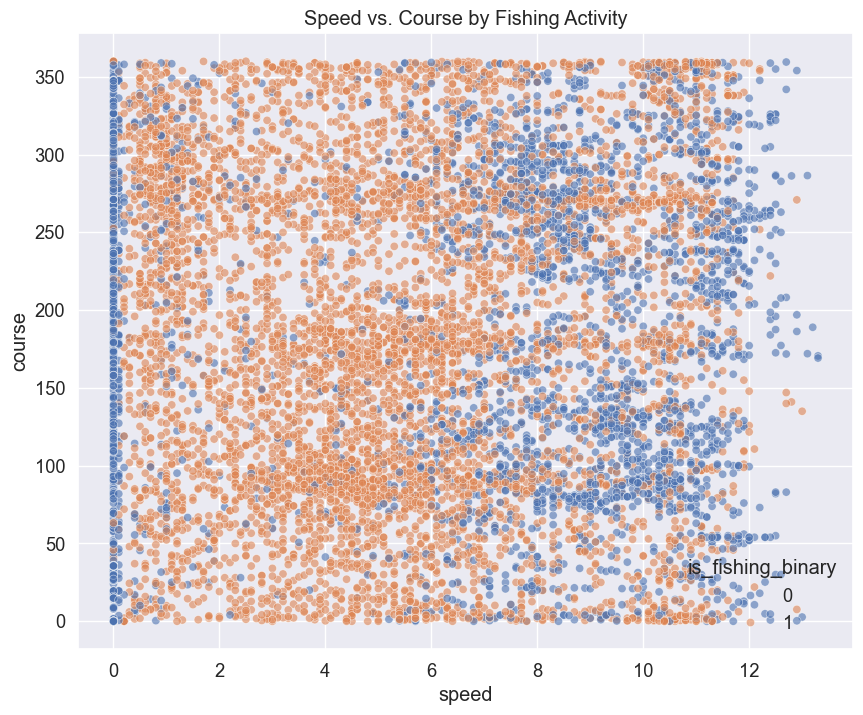

In [9]:
print("\nCreating visualizations...")

# Plot distributions of key features
features = ['speed', 'distance_from_shore', 'distance_from_port']
fig, axes = plt.subplots(len(features), 1, figsize=(12, 5*len(features)))

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, hue='is_fishing_binary', bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by fishing activity')
    axes[i].set_ylabel('Count')

plt.tight_layout()

# Time of day analysis
hourly_fishing = df.groupby('hour')['is_fishing_binary'].mean()
plt.figure(figsize=(10, 6))
hourly_fishing.plot(kind='bar')
plt.title('Fishing Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Proportion Fishing')
plt.xticks(rotation=45)
plt.tight_layout()

# Speed vs. Course Analysis
sample_df = df.sample(min(10000, len(df)))
plt.figure(figsize=(10, 8))
sns.scatterplot(data=sample_df, x='speed', y='course', hue='is_fishing_binary', alpha=0.6)
plt.title('Speed vs. Course by Fishing Activity')

# Spatial visualization (folium map)
print("\nGenerating map visualization...")
# Sample data if too large
map_sample = df.sample(min(50000, len(df)))

# Create map centered on mean coordinates
map_center = [map_sample['lat'].mean(), map_sample['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=2)

# Add fishing points in red, non-fishing in blue
for idx, row in map_sample.iterrows():
    color = 'red' if row['is_fishing_binary'] == 1 else 'blue'
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5
    ).add_to(m)

# Save the map
m.save('fishing_map.html')
print("Map saved to fishing_map.html")

## Part 4: Initial Baseline Model

Implement a random train/test split and evaluate a Random Forest classifier.


Training initial baseline model with random split...

Baseline model performance (naive random split):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15789
           1       0.99      1.00      0.99     28121

    accuracy                           0.99     43910
   macro avg       0.99      0.99      0.99     43910
weighted avg       0.99      0.99      0.99     43910


Confusion Matrix:
[[15589   200]
 [   88 28033]]

Feature importance:
               feature  importance
0                speed    0.227089
2  distance_from_shore    0.185031
3   distance_from_port    0.143596
8                  lon    0.143457
7                  lat    0.143363
6                month    0.045028
1               course    0.043829
4                 hour    0.039061
5          day_of_week    0.029547


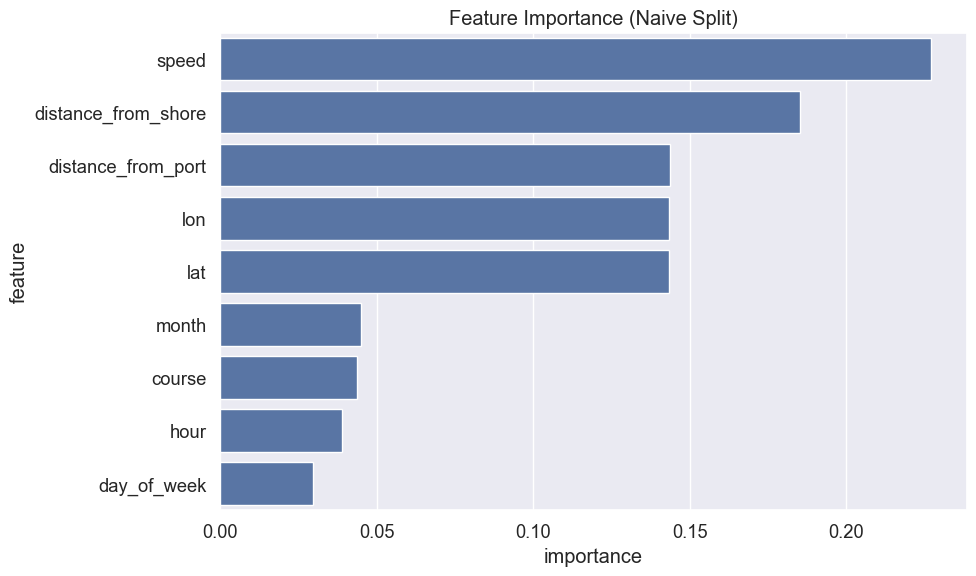

In [6]:
print("\nTraining initial baseline model with random split...")
# Prepare features and target
features = ['speed', 'course', 'distance_from_shore', 'distance_from_port', 
           'hour', 'day_of_week', 'month', 'lat', 'lon']
X = df[features].copy()
y = df['is_fishing_binary']

# Handle any remaining missing values
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# Naive random split (problematic for time series / AIS data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nBaseline model performance (naive random split):")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance:")
print(importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Feature Importance (Naive Split)')
plt.tight_layout()

# Vesel-based split model


Implementing vessel-based splitting for improved evaluation...
Total unique vessels: 110
Training vessels: 88
Testing vessels: 22
Training set size: 168305
Test set size: 51243

Improved model performance (vessel-based split):
              precision    recall  f1-score   support

           0       0.63      0.73      0.68     16247
           1       0.86      0.80      0.83     34996

    accuracy                           0.78     51243
   macro avg       0.75      0.77      0.75     51243
weighted avg       0.79      0.78      0.78     51243


Confusion Matrix (vessel-based split):
[[11868  4379]
 [ 7013 27983]]

Feature importance (vessel-based split):
               feature  importance
0                speed    0.216147
2  distance_from_shore    0.190705
7                  lat    0.147577
3   distance_from_port    0.141047
8                  lon    0.140632
6                month    0.048534
1               course    0.046180
4                 hour    0.037861
5          day_of

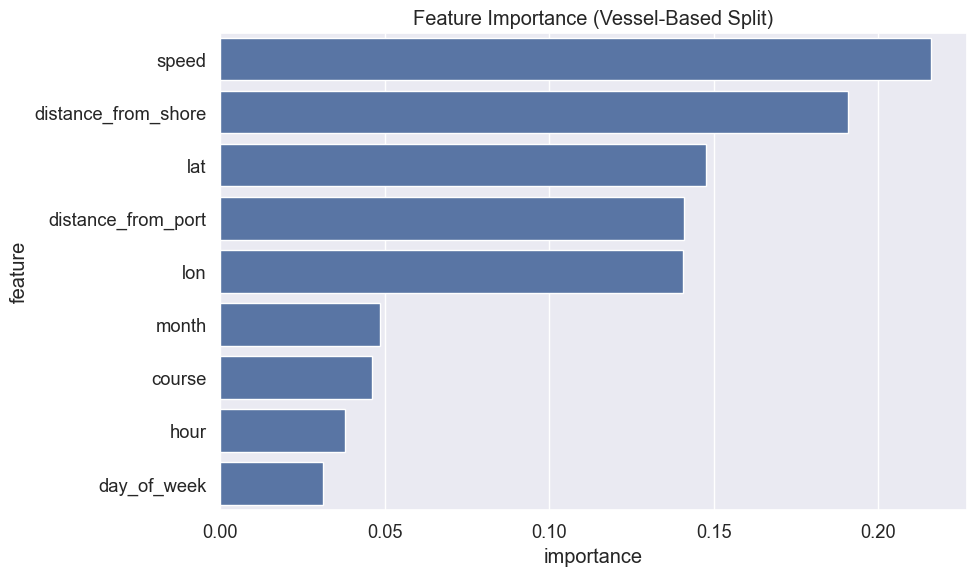

In [7]:

print("\nImplementing vessel-based splitting for improved evaluation...")

# Get unique vessel identifiers
vessels = df['mmsi'].unique()
print(f"Total unique vessels: {len(vessels)}")

# Split vessels into train/test groups
np.random.seed(42)
train_vessels, test_vessels = train_test_split(vessels, test_size=0.2, random_state=42)

print(f"Training vessels: {len(train_vessels)}")
print(f"Testing vessels: {len(test_vessels)}")

# Create train/test sets based on vessel assignment
X_train_vessel = X[df['mmsi'].isin(train_vessels)]
X_test_vessel = X[df['mmsi'].isin(test_vessels)]
y_train_vessel = y[df['mmsi'].isin(train_vessels)]
y_test_vessel = y[df['mmsi'].isin(test_vessels)]

print(f"Training set size: {len(X_train_vessel)}")
print(f"Test set size: {len(X_test_vessel)}")

# Train model with vessel-based split
model_vessel = RandomForestClassifier(n_estimators=100, random_state=42)
model_vessel.fit(X_train_vessel, y_train_vessel)

# Evaluate
y_pred_vessel = model_vessel.predict(X_test_vessel)
print("\nImproved model performance (vessel-based split):")
print(classification_report(y_test_vessel, y_pred_vessel))

print("\nConfusion Matrix (vessel-based split):")
print(confusion_matrix(y_test_vessel, y_pred_vessel))

# Feature importance for vessel-based model
importance_vessel = pd.DataFrame({
    'feature': features,
    'importance': model_vessel.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance (vessel-based split):")
print(importance_vessel)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_vessel)
plt.title('Feature Importance (Vessel-Based Split)')
plt.tight_layout()


Comparing naive and vessel-based approaches:
Naive random split accuracy: 0.9938
Vessel-based split accuracy: 0.7696
Naive Confusion matrix: 
[[15666   198]
 [   74 28011]]
Vessel Confusion matrix: 
[[11312  4935]
 [ 6870 28128]]


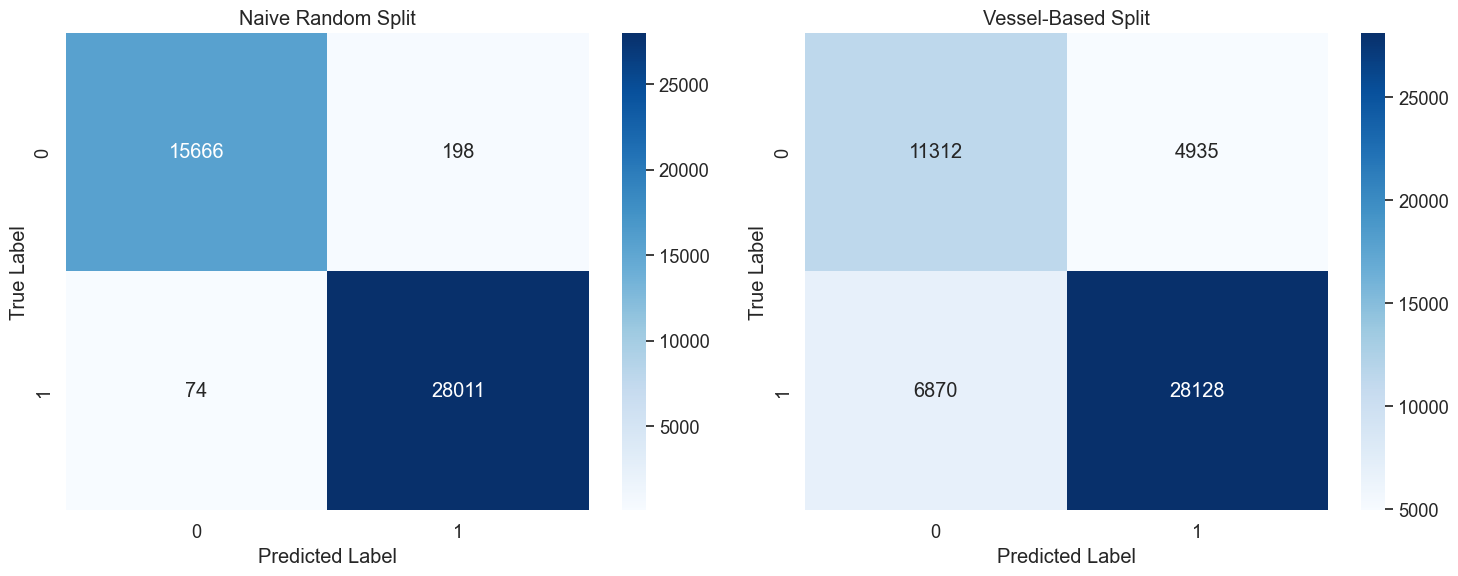

In [26]:
print("\nComparing naive and vessel-based approaches:")
print(f"Naive random split accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Vessel-based split accuracy: {accuracy_score(y_test_vessel, y_pred_vessel):.4f}")

# Create a comparison plot of the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Naive split confusion matrix
print("Naive Confusion matrix: ")
naive_cm = confusion_matrix(y_test, y_pred)
print(naive_cm)

sns.heatmap(naive_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Random Split')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')


# Vessel-based split confusion matrix
vessel_cm = confusion_matrix(y_test_vessel, y_pred_vessel)
print("Vessel Confusion matrix: ")
print(vessel_cm)
sns.heatmap(vessel_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Vessel-Based Split')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()

In [20]:
print("\nComparing naive and vessel-based approaches:")
print(f"Naive random split accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Vessel-based split accuracy: {accuracy_score(y_test_vessel, y_pred_vessel):.4f}")

# Create a comparison plot of the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Naive split confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Random Split')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Vessel-based split confusion matrix
sns.heatmap(confusion_matrix(y_test_vessel, y_pred_vessel), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Vessel-Based Split')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png')
print("Saved confusion matrix comparison plot")
plt.close()


Comparing naive and vessel-based approaches:
Naive random split accuracy: 0.9938
Vessel-based split accuracy: 0.7696
Saved confusion matrix comparison plot


## Section 5: Improved Model with Vessel-Based Splitting

Prevent data leakage by splitting data by vessel IDs.


Implementing vessel-based splitting for improved evaluation...
Total unique vessels: 110
Training vessels: 88
Testing vessels: 22
Training set size: 168496
Test set size: 51245

Improved model performance (vessel-based split):
              precision    recall  f1-score   support

           0       0.62      0.70      0.66     16247
           1       0.85      0.80      0.83     34998

    accuracy                           0.77     51245
   macro avg       0.74      0.75      0.74     51245
weighted avg       0.78      0.77      0.77     51245


Confusion Matrix (vessel-based split):
[[11312  4935]
 [ 6870 28128]]

Feature importance (vessel-based split):
               feature  importance
0                speed    0.220636
2  distance_from_shore    0.191014
7                  lat    0.147563
3   distance_from_port    0.137501
8                  lon    0.136819
6                month    0.050134
1               course    0.047767
4                 hour    0.037114
5          day_of

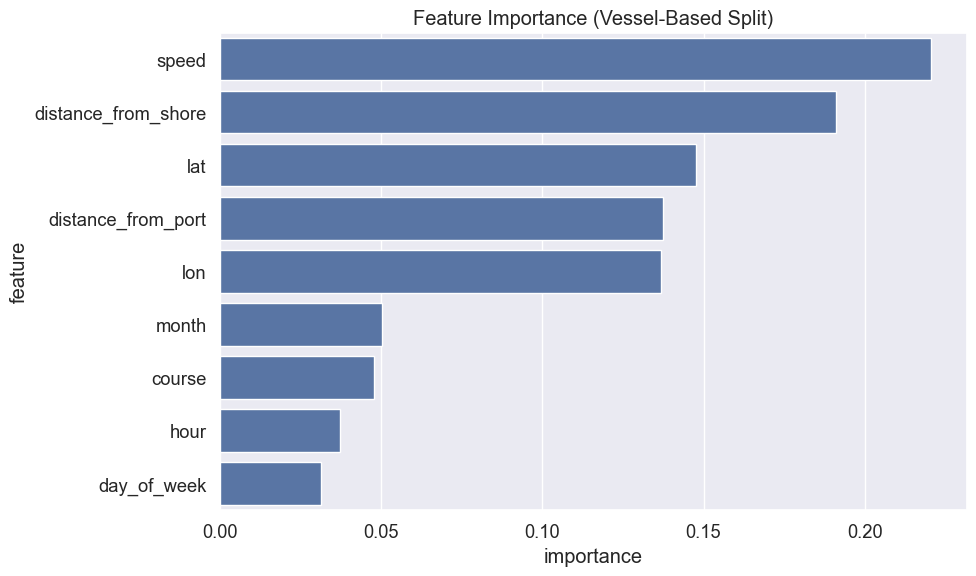

In [21]:
print("\nImplementing vessel-based splitting for improved evaluation...")

# Get unique vessel identifiers
vessels = df['mmsi'].unique()
print(f"Total unique vessels: {len(vessels)}")

# Split vessels into train/test groups
np.random.seed(42)
train_vessels, test_vessels = train_test_split(vessels, test_size=0.2, random_state=42)

print(f"Training vessels: {len(train_vessels)}")
print(f"Testing vessels: {len(test_vessels)}")

# Create train/test sets based on vessel assignment
X_train_vessel = X[df['mmsi'].isin(train_vessels)]
X_test_vessel = X[df['mmsi'].isin(test_vessels)]
y_train_vessel = y[df['mmsi'].isin(train_vessels)]
y_test_vessel = y[df['mmsi'].isin(test_vessels)]

print(f"Training set size: {len(X_train_vessel)}")
print(f"Test set size: {len(X_test_vessel)}")

# Train model with vessel-based split
model_vessel = RandomForestClassifier(n_estimators=100, random_state=42)
model_vessel.fit(X_train_vessel, y_train_vessel)

# Evaluate
y_pred_vessel = model_vessel.predict(X_test_vessel)
print("\nImproved model performance (vessel-based split):")
print(classification_report(y_test_vessel, y_pred_vessel))

print("\nConfusion Matrix (vessel-based split):")
print(confusion_matrix(y_test_vessel, y_pred_vessel))

# Feature importance for vessel-based model
importance_vessel = pd.DataFrame({
    'feature': features,
    'importance': model_vessel.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance (vessel-based split):")
print(importance_vessel)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_vessel)
plt.title('Feature Importance (Vessel-Based Split)')
plt.tight_layout()

## Section 7: Comparison and Discussion

Compare naive and vessel-based approaches.

In [22]:
print("\nComparing naive and vessel-based approaches:")
print(f"Naive random split accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Vessel-based split accuracy: {accuracy_score(y_test_vessel, y_pred_vessel):.4f}")

# Create a comparison plot of the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Naive split confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Random Split')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Vessel-based split confusion matrix
sns.heatmap(confusion_matrix(y_test_vessel, y_pred_vessel), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Vessel-Based Split')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png')
print("Saved confusion matrix comparison plot")
plt.close()


Comparing naive and vessel-based approaches:
Naive random split accuracy: 0.9938
Vessel-based split accuracy: 0.7696
Saved confusion matrix comparison plot


## Section 7: Next Steps

1. Feature Engineering: behavioral features, temporal windows, trajectory complexity
2. Model Improvements: XGBoost, LightGBM, hyperparameter optimization, class weighting
3. Evaluation: GroupKFold cross-validation, geographic generalization